# Import Model

In [1]:
from python_scripts.pretrain_model import PretrainedEncoderRegressor
import torch.nn as nn

name = 'AE_Center_noaug'

checkpoint_path = f"AE_model/version1/{name}/best.pt"

# 1) ÂÆû‰æãÂåñÔºà‰ºöËá™Âä®Âä†ËΩΩÂπ∂ÂÜªÁªì encoderÔºâ
model = PretrainedEncoderRegressor(
    ae_checkpoint=checkpoint_path,
    ae_type="center",
    center_dim=64, neighbor_dim=64, hidden_dim=128,
    tile_size=26, output_dim=35,
    freeze_encoder = True
)

# 2) monkey‚Äêpatch ‰∏Ä‰∏™Êñ∞ÁöÑ head
model.decoder  = nn.Sequential(
    nn.Linear(64+64, 256),
    nn.SiLU(),
    nn.Dropout(0.1),
    nn.Linear(256, 128),
    nn.SiLU(),
    nn.Dropout(0.1),
    nn.Linear(128, 64),
    nn.SiLU(),
    nn.Dropout(0.1),
    nn.Linear(64, 35)
    
)

# 3) ÂÜçÊ¨°Ê£ÄÊü•Âè™ËÆ≠ÁªÉ head
# for name, p in model.named_parameters():
#     print(name, p.requires_grad)



# ‚Äî‚Äî 5) Á°Æ‰øùÂè™Êúâ decoder ÂèØËÆ≠ÁªÉ ‚Äî‚Äî  
trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
total     = sum(p.numel() for p in model.parameters())
print(f"Trainable / total params = {trainable:,} / {total:,}")


Trainable / total params = 76,451 / 1,130,787


## Load Model

# Import training data

## Same in multiple .pt

In [2]:
import os
import torch
import random
import inspect
from python_scripts.import_data import load_all_tile_data

# Áî®Ê≥ïÁØÑ‰æã
#folder = "dataset/spot-rank/version-3/only_tile_sub/original_train"
folder = "dataset/spot-rank/filtered_directly_rank/masked/realign/filtered/hed_normalize_image_masked/train_data/"

grouped_data = load_all_tile_data( 
        folder_path=folder,
        model=model,
        fraction=1,
        shuffle=False
    )

    # grouped_data ÁèæÂú®Âè™ÊúÉÊúâ model.forward() ÈúÄË¶ÅÁöÑ keyÔºå
    # ÂÉè ['tile','subtiles','neighbors','norm_coord','node_feat','adj_list','edge_feat','label','source_idx']
print("Loaded keys:", grouped_data.keys())
print("Samples:", len(next(iter(grouped_data.values()))))


/opt/anaconda3/envs/spatialhackathon/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loaded keys: dict_keys(['subtiles', 'tile', 'label', 'source_idx', 'slide_idx'])
Samples: 8348


In [3]:
import os
import torch
import csv
import matplotlib.pyplot as plt
from IPython.display import clear_output, display
from torch.optim.lr_scheduler import ReduceLROnPlateau
from tqdm import tqdm
from python_scripts.operate_model import train_one_epoch, evaluate, predict, plot_losses, plot_per_cell_metrics,spear_EarlyStopping
import torch.nn as nn

# ---------------------------
# ÊåáÂÆöÂÑ≤Â≠òË≥áÊñôÂ§æ
# ---------------------------
save_folder = f"/Users/deweywang/Desktop/GitHub/HEVisum/output_folder/rank-spot/realign/pretrain/{name}/filtered_directly_rank/k-fold/realign_all/hed_normalize_image_masked"  # ‰øÆÊîπÁÇ∫‰Ω†ÊÉ≥Ë¶ÅÁöÑË≥áÊñôÂ§æÂêçÁ®±
if not os.path.exists(save_folder):
    os.makedirs(save_folder)


In [4]:
# --------------------------------------------
# 2) Âæû grouped_data ÂèñÂá∫ slide_idxÔºåËΩâÊàê numpy
# --------------------------------------------
import numpy as np
slide_idx = np.array(grouped_data['slide_idx'])   # shape (N,)

# --------------------------------------------
# 3) Âª∫Á´ã LOGOÔºàÊàñÊîπÊàê GroupKFoldÔºâ
# --------------------------------------------
from sklearn.model_selection import LeaveOneGroupOut
logo = LeaveOneGroupOut()

# X ÂèØ‰ª•Áµ¶ËôõÊì¨Áü©Èô£ÔºåÂõ†ÁÇ∫ÂàÜÁµÑÂè™Èù† groups
X_dummy = np.zeros(len(slide_idx))
X_dummy

array([0., 0., 0., ..., 0., 0., 0.])

EarlyStopping counter: 6/15
[Epoch 7]  lr=8.73e-05, train_loss=56.8514, val_loss=96.4941
train spearman: 0.6766 | Val spearman: 0.3884 | best: 0.3976


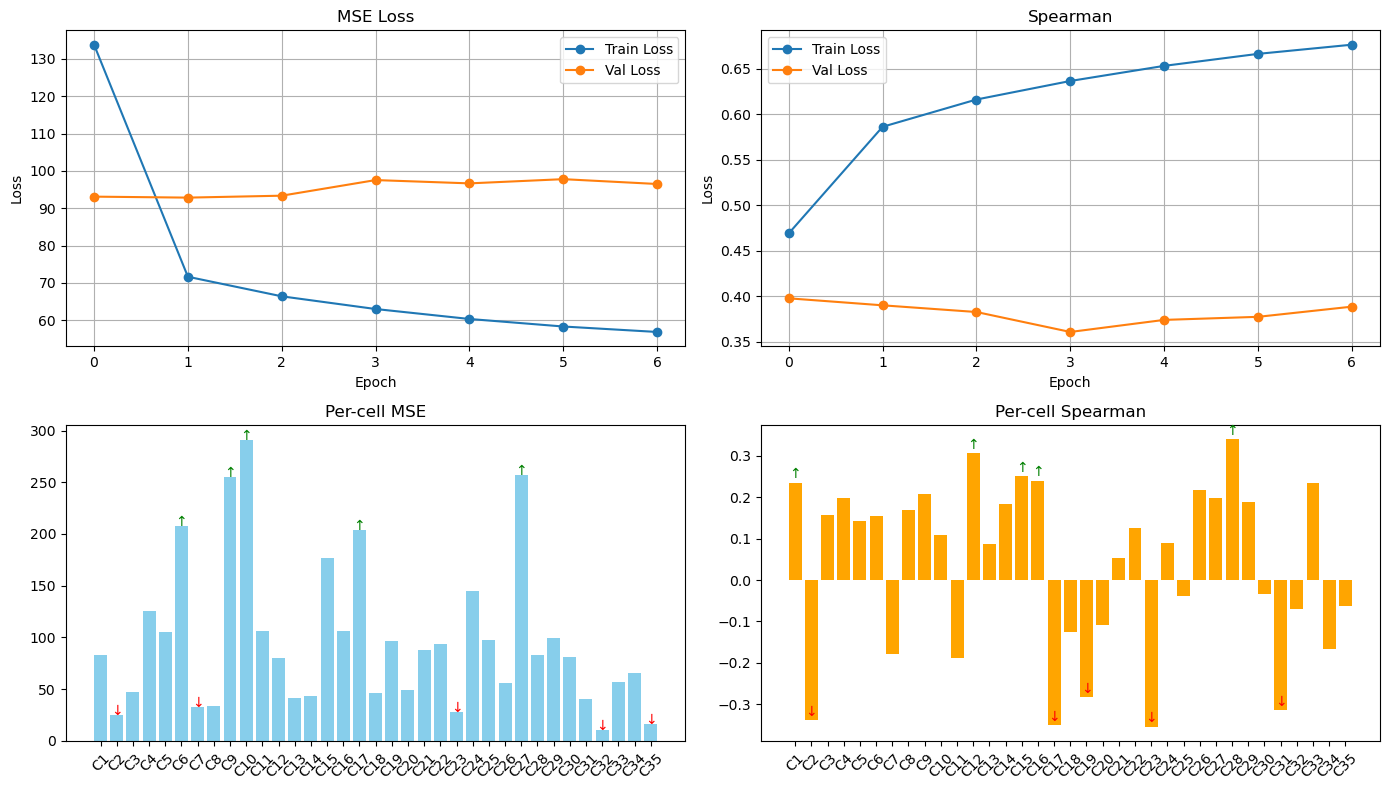

<Figure size 640x480 with 0 Axes>

Êõ≤Á∑öÂúñÂ∑≤ÂÑ≤Â≠òËá≥ /Users/deweywang/Desktop/GitHub/HEVisum/output_folder/rank-spot/realign/pretrain/AE_Center_noaug/filtered_directly_rank/k-fold/realign_all/hed_normalize_image_masked/fold0/loss_curve.png


Training:  25%|‚ñà‚ñà‚ñç       | 144/577 [00:16<00:51,  8.38it/s, avg=56, loss=60.5]  

In [ ]:
from torch.utils.data import DataLoader
from python_scripts.import_data import importDataset
from python_scripts.aug         import augment_grouped_data, identity, subset_grouped_data
import math
from torch.optim.lr_scheduler import LambdaLR
# ---------------- Âü∫Êú¨ÂèÉÊï∏ ----------------
start_fold = 0   # ‰ªéÁ¨¨Âá†‰∏™ fold ÂºÄÂßãËÆ≠ÁªÉÔºà0-basedÔºâÔºåÂ∞è‰∫éÊ≠§ÂÄºÁöÑ fold ‰ºöË∑≥Ëøá

BATCH_SIZE   = 64
num_epochs   = 150
repeats      = 5
# ---------------- ÂèÉÊï∏Ë®≠ÂÆö ----------------
save_root    = save_folder          # ÊúÄÂ§ñÂ±§
os.makedirs(save_root, exist_ok=True)

# Seed once at the very top for reproducibility

logo     = LeaveOneGroupOut()
device   = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print("‚úÖ device:", device)

overall_best = []
# Âú®‰Ω†ÁöÑËÑöÊú¨Êñá‰ª∂Â§¥ÈÉ®



# ‚ûã LOGO / GroupKFold ÂàáÂàÜÁ¥¢ÂºïÔºåÂ∞ç Dataset Âª∫ Subset
for fold_id, (tr_idx, va_idx) in enumerate(
        logo.split(X=np.zeros(len(slide_idx)), y=None, groups=slide_idx)):
    
        # Â¶ÇÊûúÂΩìÂâç fold < start_foldÔºåÂ∞±Ë∑≥Ëøá
    if fold_id < start_fold:
        print(f"‚è≠Ô∏è Skipping fold {fold_id}")
        continue
    
    print("Starting fold", fold_id)
    print("Starting subseting...")

    train_base = subset_grouped_data(grouped_data, tr_idx)
    print("Starting augmenting...")

    train_ds = augment_grouped_data(
                    grouped_data=train_base,
                    image_keys=['tile','subtiles'],
                    repeats=repeats   # ÊØîÂ¶ÇÂØπÊØèÂº†ÂÅö 2 Ê¨°Â¢ûÂº∫
                )
    print("Starting importDataset...")
    # 1) ÂéüÂßã dataset
    train_ds = importDataset(train_ds, model,
                            image_keys=['tile','subtiles'],
                            transform=identity)


    # 3) validation raw
    val_ds     = subset_grouped_data(grouped_data, va_idx)
    val_ds     = importDataset(val_ds, model,
                            image_keys=['tile','subtiles'],
                            transform=identity)

    print("Starting DataLoader...")
    # 4) DataLoader ‰∏çÂÜçÂãïÊÖãÂ¢ûÂº∑
    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE,
                              shuffle=True, num_workers=0, pin_memory=False)
    val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE,
                              shuffle=False, num_workers=0, pin_memory=False)

    # 5) ‰∏ÄÂàáÂÖ∂È§òÊ≠•È©üÂêå‰πãÂâçÔºöÂÆöÊ®°Âûã„ÄÅoptimizer„ÄÅtrain_one_epoch„ÄÅevaluate‚Ä¶‚Ä¶

    print("Starting model...")
    # ----- Êñ∞Âª∫Ê®°Âûã / ÂÑ™ÂåñÂô® -----
    net = PretrainedEncoderRegressor(
        ae_checkpoint=checkpoint_path,
        ae_type="all",
        center_dim=64, neighbor_dim=64, hidden_dim=128,
        tile_size=26, output_dim=35,
        freeze_encoder = True
    )

    # 2) monkey‚Äêpatch ‰∏Ä‰∏™Êñ∞ÁöÑ head
    net.decoder  = nn.Sequential(
        nn.Linear(64+64, 256),
        nn.SiLU(),
        nn.Dropout(0.1),
        nn.Linear(256, 128),
        nn.SiLU(),
        nn.Dropout(0.1),
        nn.Linear(128, 64),
        nn.SiLU(),
        nn.Dropout(0.1),
        nn.Linear(64, 35)
        
    )
    net = net.to(device)

    # Êàë‰ª¨ÊääÂéüÊù• Adam Êç¢Êàê AdamWÔºåÁ®çÂæÆÂä†‰∏ÄÁÇπ weight decay
    peak_lr       = 5e-4
    min_lr        = 1e-6
    warmup_epochs = 0
    total_epochs  = 30

    unfreeze_epoch = 1  # ÊØîÂ¶ÇÂú®Á¨¨ 50 ‰∏™ epoch Ëß£ÂÜª encoder
    encoder_lr     = 1e-5

    optimizer = torch.optim.AdamW(
        filter(lambda p: p.requires_grad, net.parameters()),
        lr=peak_lr, weight_decay=1e-3
    )

    # ÂÆö‰πâ lr_lambda
    def lr_lambda(cur_epoch):
        if cur_epoch < warmup_epochs:
            # Á∫øÊÄß warm-up: ‰ªé 0 ‚Üí 1
            return float(cur_epoch + 1) / warmup_epochs
        else:
            # ‰ΩôÂº¶ÈÄÄÁÅ´Ôºö‰ªé 1 ‚Üí min_lr/peak_lr
            progress = (cur_epoch - warmup_epochs) / (total_epochs - warmup_epochs)
            # cos(0)=1 ‚Üí cos(pi)=‚àí1, remap to [min_ratio,1]
            min_ratio = min_lr / peak_lr
            return min_ratio + 0.5 * (1 - min_ratio) * (1 + math.cos(math.pi * progress))

    scheduler = LambdaLR(optimizer, lr_lambda)

    stopper = spear_EarlyStopping(patience=15)

    # ----- fold Â∞àÂ±¨Ëº∏Âá∫Ë∑ØÂæë -----
    fold_dir  = os.path.join(save_folder, f"fold{fold_id}")
    os.makedirs(fold_dir, exist_ok=True)
    best_model_path = os.path.join(fold_dir, "best_model.pt")
    loss_plot_path  = os.path.join(fold_dir, "loss_curve.png")
    csv_path        = os.path.join(fold_dir, "training_log.csv")

    # ----- CSV log -----
    log_f = open(csv_path, "w", newline="")
    csv_w = csv.writer(log_f)
    csv_w.writerow(["Epoch","TrainLoss","ValLoss","ValSpearman","LR"])

    # ----- ÂúñÂΩ¢ -----
    fig, axes = plt.subplots(2, 2, figsize=(14, 8))
    display(fig)

    train_losses = []; val_losses = []
    train_rhos   = []; val_rhos   = []

    best_rho = -1.0
    print("Starting training...")
    for epoch in range(num_epochs):
        if epoch == unfreeze_epoch:
            print(f"*** Unfreezing encoder at epoch {epoch} and adding to optimizer ***")
        # Êää encoder ÁöÑÂèÇÊï∞Ëß£ÂÜªÂπ∂Âä†ÂÖ• optimizer
            net.unfreeze_encoder(lr=encoder_lr, optimizer=optimizer)

        tloss, trho = train_one_epoch(
            net, train_loader, optimizer, device,
            current_epoch=epoch, initial_alpha=0, final_alpha=0, target_epoch=20 )

        vloss, vrho, mse_cell, rho_cell = evaluate(
            net, val_loader, device,
            current_epoch=epoch, initial_alpha=0, final_alpha=0, target_epoch=20 )

        clear_output(wait=True)  # Ê∏ÖÈô§‰πãÂâçÁöÑËº∏Âá∫
        axes[0][0].clear()
        axes[0][1].clear()
        axes[1][0].clear()
        axes[1][1].clear()
        # --- save best ---
        if vrho > best_rho:
            best_rho = vrho
            torch.save(net.state_dict(), best_model_path)
            print(f"‚úÖ Saved best model in {best_model_path}!")

        # --- scheduler / early stop ---
        scheduler.step()
        stopper(vrho)


    
        # --- logging ---
        lr = optimizer.param_groups[0]['lr']
        csv_w.writerow([epoch+1, tloss, vloss, vrho, lr])

        train_losses.append(tloss); val_losses.append(vloss)
        train_rhos.append(trho);   val_rhos.append(vrho)
        

        

        # Âç∞Âá∫ Epoch ÁµêÊûú
        lr = optimizer.param_groups[0]['lr']
        print(f"[Epoch {epoch+1}]  lr={lr:.2e}, train_loss={tloss:.4f}, val_loss={vloss:.4f}")
        print(f"train spearman: {trho:.4f} | Val spearman: {vrho:.4f} | best: {best_rho:.4f}")
        # --- update plots ---
        plot_losses(train_losses, val_losses, axes[0][0], "MSE Loss")
        plot_losses(train_rhos,   val_rhos,   axes[0][1], "Spearman")
        cell_names = [f"C{i+1}" for i in range(35)]
        plot_per_cell_metrics(mse_cell, rho_cell, cell_names,
                              ax_mse=axes[1][0], ax_spearman=axes[1][1])
        plt.tight_layout(); display(fig); plt.pause(0.1)
        fig.savefig(loss_plot_path)
        print(f"Êõ≤Á∑öÂúñÂ∑≤ÂÑ≤Â≠òËá≥ {loss_plot_path}")
        if stopper.early_stop:
            print("‚õî early stop"); break

    log_f.close(); plt.close(fig)
    overall_best.append(best_rho) 
    print(f"üìà Fold {fold_id} best œÅ = {best_rho:.4f}")

# ========= Êï¥È´îÁµêÊûú =========
overall_best = np.array(overall_best)
print("\n=========== CV summary ===========")
for i, r in enumerate(overall_best):
    print(f"fold {i}: best œÅ = {r:.4f}")
print(f"overall best (mean) œÅ = {overall_best.mean():.4f} ¬± {overall_best.std():.4f}")

In [13]:
import os
import numpy as np
import joblib
import torch
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.multioutput import MultiOutputRegressor
import lightgbm as lgb
from scipy.stats import rankdata
from python_scripts.import_data import importDataset
from python_scripts.operate_model import predict

full_dataset = importDataset(grouped_data, model,
                             image_keys=['tile','subtiles'],
                             transform=lambda x: x)
# ---------------- Settings ----------------
save_root  = save_folder  # your save_folder path
n_folds    = len([d for d in os.listdir(save_root) if d.startswith('fold')])
n_samples  = len(full_dataset)
C          = 35  # num cell types
start_fold = 0
BATCH_SIZE = 64
# If optimizing Spearman, convert labels to ranks
use_rank   = False

# --- 1) Prepare OOF meta-features ---
# Initialize matrix for OOF predictions
n_samples = len(full_dataset)
oof_preds = np.zeros((n_samples, C), dtype=np.float32)
# True labels (raw or rank)
# importDataset returns a dict-like sample, so label is under key 'label'
y_true = np.vstack([ full_dataset[i]['label'].cpu().numpy() for i in range(n_samples) ])
if use_rank:
    y_meta = np.apply_along_axis(rankdata, 1, y_true)
else:
    y_meta = y_true

# Build CV splitter (must match first stage splits)
logo = LeaveOneGroupOut()

# Loop over folds, load best model, predict on validation indices
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
for fold_id, (tr_idx, va_idx) in enumerate(
        logo.split(X=np.zeros(n_samples), y=None, groups=slide_idx)):
    # Load model
    if fold_id > start_fold:
        print(f"‚è≠Ô∏è Skipping fold {fold_id}")
        continue
    ckpt_path = os.path.join(save_root, f"fold{fold_id}", "best_model.pt")
    print(f"Loading model from {ckpt_path}...")
    net = model.to(device)
    # Alternatively, if your model requires specific args, replace with:
    # net = VisionMLP_MultiTask(tile_dim=64, subtile_dim=64, output_dim=35).to(device)
    net.load_state_dict(torch.load(ckpt_path, map_location=device))
    net.to(device).eval()

    # Predict on validation set
    val_ds = Subset(full_dataset, va_idx)
    val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)
    preds = predict(net, val_loader, device)  # (n_val, C)
    oof_preds[va_idx] = preds
    print(f"Fold {fold_id}: OOF preds shape {preds.shape}")

# --- 2) Train LightGBM meta-model ---
# Choose objective: regression on rank (for Spearman) or raw (for MSE)
lgb_base = lgb.LGBMRegressor(
    objective='regression',
    learning_rate=0.001,
    n_estimators=1000,
    num_leaves=31,
    subsample=0.7,
    colsample_bytree=0.7,
    n_jobs=-1,
    force_col_wise=True
)
meta_model = MultiOutputRegressor(lgb_base)
print("Training LightGBM on OOF meta-features...")
meta_model.fit(oof_preds, y_meta)
# Save meta-model
joblib.dump(meta_model, os.path.join(save_root, 'meta_model.pkl'))

# --- 3) Prepare test meta-features ---
n_test = len(test_dataset)
test_meta = np.zeros((n_test, C), dtype=np.float32)
for fold_id in range(n_folds):
    ckpt_path = os.path.join(save_root, f"fold{fold_id}", "best_model.pt")
    net = model.to(device)
    net.load_state_dict(torch.load(ckpt_path, map_location=device))
    net.to(device).eval()
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
    preds = predict(net, test_loader, device)
    test_meta += preds
# Average across folds
test_meta /= n_folds

# --- 4) Meta-model predict ---
if use_rank:
    final_preds = meta_model.predict(test_meta) / (C + 1)
else:
    final_preds = meta_model.predict(test_meta)

# --- Save submission ---
import h5py
import pandas as pd
with h5py.File("./dataset/elucidata_ai_challenge_data.h5","r") as f:
    test_spot_ids = pd.DataFrame(np.array(f["spots/Test"]["S_7"]))
sub = pd.DataFrame(final_preds, columns=[f"C{i+1}" for i in range(C)])
sub.insert(0, 'ID', test_spot_ids.index)
sub.to_csv(os.path.join(save_root, 'submission_stacked.csv'), index=False)
print("‚úÖ Saved stacked submission.")


Loading model from /Users/deweywang/Desktop/GitHub/HEVisum/output_folder/rank-spot/realign/pretrain/AE_Center_noaug/filtered_directly_rank/k-fold/realign_all/hed_normalize_image_masked/fold0/best_model.pt...
Fold 0: OOF preds shape (2197, 35)
‚è≠Ô∏è Skipping fold 1
‚è≠Ô∏è Skipping fold 2
‚è≠Ô∏è Skipping fold 3
‚è≠Ô∏è Skipping fold 4
‚è≠Ô∏è Skipping fold 5
Training LightGBM on OOF meta-features...
[LightGBM] [Info] Total Bins 8925
[LightGBM] [Info] Number of data points in the train set: 8348, number of used features: 35
[LightGBM] [Info] Start training from score 26.067920
[LightGBM] [Info] Total Bins 8925
[LightGBM] [Info] Number of data points in the train set: 8348, number of used features: 35
[LightGBM] [Info] Start training from score 27.408960
[LightGBM] [Info] Total Bins 8925
[LightGBM] [Info] Number of data points in the train set: 8348, number of used features: 35
[LightGBM] [Info] Start training from score 26.489938
[LightGBM] [Info] Total Bins 8925
[LightGBM] [Info] Number o

/opt/anaconda3/envs/spatialhackathon/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/spatialhackathon/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/spatialhackathon/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/spatialhackathon/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/spatialhackathon/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature na

‚úÖ Saved stacked submission.


In [11]:
import os
import numpy as np
import joblib
import torch
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.multioutput import MultiOutputRegressor
import lightgbm as lgb
from scipy.stats import rankdata
from python_scripts.import_data import importDataset
from python_scripts.operate_model import predict

# --- ÈÖçÁΩÆ: Âè™Áî®Âì™‰∫õ fold ÁöÑÁªìÊûúÊù•ËÆ≠ÁªÉ/È¢ÑÊµã meta-model ---
meta_folds = [0,1,2,3,4,5]  # ‰æãÂ¶ÇÂè™Áî® fold0, fold2, fold4

# 1) ÂáÜÂ§á full_dataset, slide_idx, test_dataset Á≠â
full_dataset = importDataset(
    grouped_data, model,
    image_keys=['tile','subtiles'],
    transform=lambda x: x
)
n_samples = len(full_dataset)
C = 35  # Á±ªÂà´Êï∞

# 2) È¢ÑÁïô oof_preds Âíå fold_ids
oof_preds    = np.zeros((n_samples, C), dtype=np.float32)
oof_fold_ids = np.full(n_samples, -1, dtype=int)

# ÁúüÊ†áÁ≠æ
y_true = np.vstack([ full_dataset[i]['label'].cpu().numpy() for i in range(n_samples) ])
y_meta = y_true.copy()  # ‰∏çÂÅö rank Êó∂Áõ¥Êé•Áî® raw

# 3) ÁîüÊàê OOF È¢ÑÊµãÂπ∂ËÆ∞ÂΩï fold id
logo = LeaveOneGroupOut()
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

for fold_id, (tr_idx, va_idx) in enumerate(
        logo.split(X=np.zeros(n_samples), y=None, groups=slide_idx)):

    # Â¶ÇÊûúÂΩìÂâç fold ‰∏çÂú®Êàë‰ª¨ÊÉ≥Ë¶ÅÁöÑ meta_folds ÂàóË°®ÈáåÔºåÂ∞±Ë∑≥Ëøá
    if fold_id not in meta_folds:
        print(f"‚è≠Ô∏è Skipping OOF for fold {fold_id}")
        continue

    print(f"\n>>> Generating OOF for fold {fold_id}")
    ckpt_path = os.path.join(save_root, f"fold{fold_id}", "best_model.pt")
    net = PretrainedEncoderRegressor(
        ae_checkpoint=checkpoint_path,
        ae_type="all",
        center_dim=64, neighbor_dim=64, hidden_dim=128,
        tile_size=26, output_dim=35,
        freeze_encoder = True
    )

    # 2) monkey‚Äêpatch ‰∏Ä‰∏™Êñ∞ÁöÑ head
    net.decoder  = nn.Sequential(
        nn.Linear(64+64, 256),
        nn.SiLU(),
        nn.Dropout(0.1),
        nn.Linear(256, 128),
        nn.SiLU(),
        nn.Dropout(0.1),
        nn.Linear(128, 64),
        nn.SiLU(),
        nn.Dropout(0.1),
        nn.Linear(64, 35)
        
    )
    net = net.to(device)
    net.load_state_dict(torch.load(ckpt_path, map_location=device))
    net.eval()

    val_loader = DataLoader(Subset(full_dataset, va_idx), batch_size=BATCH_SIZE, shuffle=False)
    preds = predict(net, val_loader, device)  # (n_val, C)

    oof_preds[va_idx]    = preds
    oof_fold_ids[va_idx] = fold_id

    print(f"  ‚Üí Fold {fold_id} OOF preds shape: {preds.shape}")
# 4) Âè™ÈÄâÂèñ meta_folds ÁöÑË°åÊù•ËÆ≠ÁªÉ meta-model
mask = np.isin(oof_fold_ids, meta_folds)
X_meta = oof_preds[mask]
y_meta_sub = y_meta[mask]

print(f"\nTraining meta-model on folds {meta_folds}:")
print(f"  ‰ΩøÁî®Ê†∑Êú¨Êï∞Ôºö{X_meta.shape[0]} / {n_samples}")

lgb_base = lgb.LGBMRegressor(
    objective='regression',
    learning_rate=0.001,
    n_estimators=1000,
    num_leaves=31,
    subsample=0.7,
    colsample_bytree=0.7,
    n_jobs=-1,
    force_col_wise=True
)
meta_model = MultiOutputRegressor(lgb_base)
meta_model.fit(X_meta, y_meta_sub)
joblib.dump(meta_model, os.path.join(save_root, 'meta_model.pkl'))

# 5) ÂáÜÂ§á test_metaÔºåÂè™Âπ≥Âùá meta_folds ‰∏≠ÁöÑÈ¢ÑÊµã
n_folds = len([d for d in os.listdir(save_root) if d.startswith('fold')])
n_test  = len(test_dataset)
test_meta = np.zeros((n_test, C), dtype=np.float32)

for fold_id in range(n_folds):
    if fold_id not in meta_folds:
        continue
    ckpt_path = os.path.join(save_root, f"fold{fold_id}", "best_model.pt")
    net = PretrainedEncoderRegressor(
        ae_checkpoint=checkpoint_path,
        ae_type="all",
        center_dim=64, neighbor_dim=64, hidden_dim=128,
        tile_size=26, output_dim=35,
        freeze_encoder = True
    )

    # 2) monkey‚Äêpatch ‰∏Ä‰∏™Êñ∞ÁöÑ head
    net.decoder  = nn.Sequential(
        nn.Linear(64+64, 256),
        nn.SiLU(),
        nn.Dropout(0.1),
        nn.Linear(256, 128),
        nn.SiLU(),
        nn.Dropout(0.1),
        nn.Linear(128, 64),
        nn.SiLU(),
        nn.Dropout(0.1),
        nn.Linear(64, 35)
        
    )
    net = net.to(device)
    net.load_state_dict(torch.load(ckpt_path, map_location=device))
    net.eval()

    loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
    preds = predict(net, loader, device)
    test_meta += preds

# Âπ≥ÂùáÊó∂Èô§‰ª•ÂèÇ‰∏éÁöÑ folds Êï∞ÁõÆ
test_meta /= len(meta_folds)

# 6) Áî® meta-model ÂÅöÊúÄÁªàÈ¢ÑÊµã
final_preds = meta_model.predict(test_meta)

# --- Save submission ---
import h5py
import pandas as pd

with h5py.File("./dataset/elucidata_ai_challenge_data.h5","r") as f:
    test_spot_ids = pd.DataFrame(np.array(f["spots/Test"]["S_7"]))

sub = pd.DataFrame(final_preds, columns=[f"C{i+1}" for i in range(C)])
sub.insert(0, 'ID', test_spot_ids.index)
sub.to_csv(os.path.join(save_root, 'submission_stacked.csv'), index=False)
print("‚úÖ Saved stacked submission.")



>>> Generating OOF for fold 0
  ‚Üí Fold 0 OOF preds shape: (2197, 35)

>>> Generating OOF for fold 1
  ‚Üí Fold 1 OOF preds shape: (2269, 35)

>>> Generating OOF for fold 2
  ‚Üí Fold 2 OOF preds shape: (690, 35)

>>> Generating OOF for fold 3
  ‚Üí Fold 3 OOF preds shape: (1187, 35)

>>> Generating OOF for fold 4
  ‚Üí Fold 4 OOF preds shape: (1677, 35)

>>> Generating OOF for fold 5
  ‚Üí Fold 5 OOF preds shape: (328, 35)

Training meta-model on folds [0, 1, 2, 3, 4, 5]:
  ‰ΩøÁî®Ê†∑Êú¨Êï∞Ôºö8348 / 8348
[LightGBM] [Info] Total Bins 8925
[LightGBM] [Info] Number of data points in the train set: 8348, number of used features: 35
[LightGBM] [Info] Start training from score 26.067920
[LightGBM] [Info] Total Bins 8925
[LightGBM] [Info] Number of data points in the train set: 8348, number of used features: 35
[LightGBM] [Info] Start training from score 27.408960
[LightGBM] [Info] Total Bins 8925
[LightGBM] [Info] Number of data points in the train set: 8348, number of used features: 35
[L

/opt/anaconda3/envs/spatialhackathon/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/spatialhackathon/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/spatialhackathon/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/spatialhackathon/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/spatialhackathon/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature na

‚úÖ Saved stacked submission.


In [12]:
import os
import numpy as np
import joblib
from scipy.stats import rankdata
import lightgbm as lgb
from sklearn.model_selection import LeaveOneGroupOut
from torch.utils.data import DataLoader, Subset
from python_scripts.import_data import importDataset
from python_scripts.operate_model import predict


# --- ÈÖçÁΩÆ ---
meta_folds = [0,1,2,3,4,5]  # ‰æãÂ¶ÇÂè™Áî® fold0, fold2, fold4
C          = 35       # cell type Êï∞Èáè
BATCH_SIZE = 64

# 1) ÂØºÂÖ• full_dataset, slide_idx, test_dataset
full_dataset = importDataset(grouped_data, model,
                             image_keys=['tile','subtiles'],
                             transform=lambda x: x)
n_spots = len(full_dataset)

# 2) ÁîüÊàê OOF preds & ËÆ∞ÂΩï fold id (Âêå‰Ω†‰πãÂâçÂÅöÊ≥ï)
oof_preds    = np.zeros((n_spots, C), dtype=np.float32)
oof_fold_ids = np.full(n_spots, -1, dtype=int)
logo = LeaveOneGroupOut()
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

for fold_id, (tr_idx, va_idx) in enumerate(
        logo.split(X=np.zeros(n_spots), y=None, groups=slide_idx)):
    if fold_id not in meta_folds:
        continue
    # load CNN model & predict
    ckpt = os.path.join(save_root, f"fold{fold_id}", "best_model.pt")
    net  = model.to(device)
    net.load_state_dict(torch.load(ckpt, map_location=device))
    net.eval()
    loader = DataLoader(Subset(full_dataset, va_idx),
                        batch_size=BATCH_SIZE, shuffle=False)
    preds = predict(net, loader, device)  # (n_val, C)
    oof_preds[va_idx]    = preds
    oof_fold_ids[va_idx] = fold_id

# ÁúüÊ†áÁ≠æÁü©Èòµ (n_spots, C)
y_true = np.vstack([ full_dataset[i]['label'].cpu().numpy()
                     for i in range(n_spots) ])

# 3) Á≠õÂá∫ meta_folds ÁöÑË°å
mask       = np.isin(oof_fold_ids, meta_folds)
X_meta     = oof_preds[mask]    # (N_meta, C)
y_meta     = y_true[mask]       # (N_meta, C)
slides_sub = slide_idx[mask]    # (N_meta,)

N_meta = X_meta.shape[0]

docs_feat = X_meta.reshape(-1, 1)   # ÂèòÊàê (N_meta * 35, 1)

# ÂØπÂ∫îÁöÑÁúüÂÆû abundanceÔºå‰πüË¶Å flatten
docs_true = y_meta.reshape(-1,)     # (N_meta * 35,)

# ÊØè‰∏™ spot ÈáåÂØπ 35 ‰∏™ abundance ÂÅö ordinal ÊéíÔºåÂç≥ relevance label
docs_rel = np.zeros_like(docs_true, dtype=int)
for i in range(X_meta.shape[0]):
    start = i * C
    end   = start + C
    docs_rel[start:end] = rankdata(
        docs_true[start:end],
        method='ordinal'
    ) - 1          # ÂèòÊàê 0‚Äêbased

# Flatten ‰πãÂêéÁöÑ groupÔºöÊØè‰∏™ spot ‰∏ãÂõ∫ÂÆö 35 Êù° doc
train_group = [C] * X_meta.shape[0]  # e.g. [35,35,35, ...] ÈïøÂ∫¶ = N_meta

# ------------------------ 2) ËÆ≠ÁªÉ‰∏Ä‰∏™ LGBMRanker ------------------------
ranker = lgb.LGBMRanker(
    objective='lambdarank',
    metric='ndcg@35',      # ‰πüÂèØ‰ª•Âè™ÂÖ≥Ê≥® ndcg@5„ÄÅ@10
    label_gain=list(range(docs_rel.max()+1)),
    learning_rate=1e-3,
    n_estimators=1000,
    num_leaves=31,
    subsample=0.7,
    colsample_bytree=0.7,
    n_jobs=-1
)
ranker.fit(
    docs_feat,   # (N_meta*35, 1)
    docs_rel,    # (N_meta*35,)
    group=train_group
)

# ------------------------ 3) ÊµãËØïÊó∂ÂêåÊ†∑ Flatten + Predict ------------------------
# 5) ÂáÜÂ§á test_metaÔºåÂè™Âπ≥Âùá meta_folds ‰∏≠ÁöÑÈ¢ÑÊµã
n_folds = len([d for d in os.listdir(save_root) if d.startswith('fold')])
n_test  = len(test_dataset)
test_meta = np.zeros((n_test, C), dtype=np.float32)

for fold_id in range(n_folds):
    if fold_id not in meta_folds:
        continue
    ckpt_path = os.path.join(save_root, f"fold{fold_id}", "best_model.pt")
    net = model.to(device)
    net.load_state_dict(torch.load(ckpt_path, map_location=device))
    net.eval()

    loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
    preds = predict(net, loader, device)
    test_meta += preds

# Âπ≥ÂùáÊó∂Èô§‰ª•ÂèÇ‰∏éÁöÑ folds Êï∞ÁõÆ
test_meta /= len(meta_folds)

docs_test_feat = test_meta.reshape(-1, 1)     # (n_test*35, 1)
test_group     = [C] * test_meta.shape[0]    # [35, 35, ..., 35]

docs_test_score = ranker.predict(docs_test_feat, group=test_group)  # (n_test*35,)

# ÊääÂàÜÊï∞ reshape Âõû (n_test, 35)
scores = docs_test_score.reshape(test_meta.shape[0], C)  


final_scores = test_meta*scores
# 6) ÂÜôÂÖ• submission
import pandas as pd, h5py


with h5py.File("./dataset/elucidata_ai_challenge_data.h5","r") as f:
    test_spot_ids = pd.DataFrame(np.array(f["spots/Test"]["S_7"]))

sub = pd.DataFrame(final_scores, columns=[f"C{i+1}" for i in range(C)])
sub.insert(0, 'ID', test_spot_ids.index)
sub.to_csv(os.path.join(save_root, 'submission_LGBMRanker.csv'), index=False)
print("‚úÖ Saved stacked submission.")

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001748 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 292180, number of used features: 1


/opt/anaconda3/envs/spatialhackathon/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRanker was fitted with feature names
  warnings.warn(


‚úÖ Saved stacked submission.


# Predict

In [7]:
import torch
import inspect
from python_scripts.operate_model import get_model_inputs

def load_node_feature_data(pt_path: str, model, num_cells: int = 35) -> dict:
    """
    Ê†πÊçÆ model.forward ÁöÑÂèÇÊï∞Ëá™Âä®Âä†ËΩΩ .pt ÈáåÂØπÂ∫îÁöÑÂ≠óÊÆµÔºå
    Âπ∂‰∏îÂ¶ÇÊûúÊ≤°Êúâ labelÔºåÂ∞±Ëá™Âä®ÂàõÂª∫‰∏Ä‰∏™ÂÖ® 0 ÁöÑ label Âº†ÈáèÔºå
    ÂÖ∂Â∞∫ÂØ∏‰∏∫ (Ê†∑Êú¨Êï∞, num_cells)ÔºåÊ†∑Êú¨Êï∞‰ªéÁ¨¨‰∏Ä‰∏™Êúâ __len__ ÁöÑËæìÂÖ•Êé®Êñ≠„ÄÇ

    ÂèÇÊï∞Ôºö
      pt_path:     strÔºå.pt Êñá‰ª∂Ë∑ØÂæÑ
      model:       Â∑≤ÂÆû‰æãÂåñÁöÑ PyTorch Ê®°Âûã
      num_cells:   intÔºålabel ÁöÑÂàóÊï∞ÔºàÈªòËÆ§ 35Ôºâ

    ËøîÂõûÔºö
      dict: key ÂØπÂ∫îÊ®°Âûã forward ‰∏≠ÁöÑÂèÇÊï∞ÂêçÔºà‰∏çÂê´ selfÔºâÔºå
            value ÊòØÂØπÂ∫îÁöÑ Tensor/ndarrayÔºå
            Âπ∂È¢ùÂ§ñ‰øùËØÅÊúâ 'label' Â≠óÊÆµ„ÄÇ
    """
    # 1) ËΩΩÂÖ•ÂéüÂßãÊï∞ÊçÆ
    raw = torch.load(pt_path, map_location="cpu")

    # 2) ÂèñÊ®°Âûã forward ÂÖ•ÂèÇÁ≠æÂêçÔºà‰∏çÂê´ selfÔºâ
    sig = inspect.signature(model.forward)
    param_names = [p for p in sig.parameters if p != "self"]

    out = {}
    for name in param_names:
        # a) Áõ¥Êé•ÂêåÂêç
        if name in raw:
            out[name] = raw[name]
            continue
        # b) Â§çÊï∞ÂΩ¢Âºè
        if name + "s" in raw:
            out[name] = raw[name + "s"]
            continue
        # c) Ê®°Á≥äÂåπÈÖçÔºà‰∏ãÂàíÁ∫ø„ÄÅÂ§çÊï∞ÊàñÂâçÂêéÁºÄÔºâ
        cands = [k for k in raw if name in k or k in name]
        if len(cands) == 1:
            out[name] = raw[cands[0]]
            continue
        raise KeyError(f"Êó†Ê≥ïÊâæÂà∞ '{name}' Âú® pt Êñá‰ª∂‰∏≠ÁöÑÂØπÂ∫îÂ≠óÊÆµÔºåraw keys: {list(raw.keys())}")

    # 3) Áî®Á¨¨‰∏Ä‰∏™ÊîØÊåÅ len() ÁöÑËæìÂÖ•Êé®Êñ≠Ê†∑Êú¨Êï∞
    dataset_size = None
    for v in out.keys():
        if hasattr(out[v], "__len__"):
            dataset_size = len(out[v])
            print(f"‚ö†Ô∏è ‰ªé '{v}' Êé®Êñ≠Ê†∑Êú¨Êï∞Èáè: {dataset_size}")
            break
    if dataset_size is None:
        raise RuntimeError("Êó†Ê≥ï‰ªé‰ªª‰ΩïËæìÂÖ•‰∏≠Êé®Êñ≠Ê†∑Êú¨Êï∞ÈáèÔºåËØ∑Ê£ÄÊü• pt Êñá‰ª∂ÂÜÖÂÆπ„ÄÇ")

    # 4) Ëá™Âä®Ë°• label

    out["label"] = torch.zeros((dataset_size, num_cells), dtype=torch.float32)
    return out


image_keys = [ 'tile', 'subtiles']


# Áî®Ê≥ïÁ§∫‰æã
from python_scripts.import_data import importDataset
# ÂÅáËÆæ‰Ω†ÁöÑ model Â∑≤ÁªèÂÆö‰πâÂ•ΩÂπ∂ÂÆû‰æãÂåñ‰∏∫ `model`
test_dataset = load_node_feature_data("dataset/spot-rank/filtered_directly_rank/masked/test/hed_normalize_image/test_dataset.pt", model)
test_dataset = importDataset(
        data_dict=test_dataset,
        model=model,
        image_keys=image_keys,
        transform=lambda x: x,  # identity transform
        print_sig=True
    )



‚ö†Ô∏è ‰ªé 'tile' Êé®Êñ≠Ê†∑Êú¨Êï∞Èáè: 2088
Model forward signature: (tile, subtiles)


In [ ]:

test_dataset.check_item(1000, 10)


In [8]:
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [10]:
import glob
import torch
import numpy as np
import pandas as pd
import os
import h5py
from torch.utils.data import DataLoader

# ËÆÄ test spot index
with h5py.File("./dataset/elucidata_ai_challenge_data.h5","r") as f:
    test_spots     = f["spots/Test"]
    test_spot_table= pd.DataFrame(np.array(test_spots['S_7']))

fold_ckpts = sorted(glob.glob(os.path.join(save_folder, "fold*", "best_model.pt")))
models = []
for ckpt in fold_ckpts:
    net = PretrainedEncoderRegressor(
        ae_checkpoint=checkpoint_path,
        ae_type="all",
        center_dim=64, neighbor_dim=64, hidden_dim=128,
        tile_size=26, output_dim=35,
        freeze_encoder = False
    )

    # 2) monkey‚Äêpatch ‰∏Ä‰∏™Êñ∞ÁöÑ head
    net.decoder  = nn.Sequential(
        nn.Linear(64+64, 256),
        nn.SiLU(),
        nn.Dropout(0.1),
        nn.Linear(256, 128),
        nn.SiLU(),
        nn.Dropout(0.1),
        nn.Linear(128, 64),
        nn.SiLU(),
        nn.Dropout(0.1),
        nn.Linear(64, 35)
        
    )
    net = net.to(device)
    net.load_state_dict(torch.load(ckpt, map_location="cpu"))
    net.to(device).eval()
    models.append(net)

all_fold_preds = []
for fold_id, net in enumerate(models):
    # Êé®Ë´ñ
    with torch.no_grad():
        preds = predict(net, test_loader, device)  # (N_test,35) numpy array

    # 1) Â≠òÊØè‰∏ÄÊäòÁöÑÂéüÂßãÈ†êÊ∏¨
    df_fold = pd.DataFrame(preds, columns=[f"C{i+1}" for i in range(preds.shape[1])])
    df_fold.insert(0, "ID", test_spot_table.index)
    path_fold = os.path.join(save_folder, f"submission_fold{fold_id}.csv")
    df_fold.to_csv(path_fold, index=False)
    print(f"‚úÖ Saved fold {fold_id} predictions to {path_fold}")

    all_fold_preds.append(preds)

# 2) ÂÅö rank‚Äêaverage ensemble
all_fold_preds = np.stack(all_fold_preds, axis=0)       # (K, N_test, 35)
ranks          = all_fold_preds.argsort(axis=2).argsort(axis=2).astype(float)
mean_rank      = ranks.mean(axis=0)                    # (N_test,35)

# 3) Â≠ò final ensemble
df_ens = pd.DataFrame(mean_rank, columns=[f"C{i+1}" for i in range(mean_rank.shape[1])])
df_ens.insert(0, "ID", test_spot_table.index)
path_ens = os.path.join(save_folder, "submission_rank_ensemble.csv")
df_ens.to_csv(path_ens, index=False)
print(f"‚úÖ Saved rank‚Äêensemble submission to {path_ens}")


‚úÖ Saved fold 0 predictions to /Users/deweywang/Desktop/GitHub/HEVisum/output_folder/rank-spot/realign/pretrain/AE_Center_noaug/filtered_directly_rank/k-fold/realign_all/hed_normalize_image_masked/submission_fold0.csv
‚úÖ Saved fold 1 predictions to /Users/deweywang/Desktop/GitHub/HEVisum/output_folder/rank-spot/realign/pretrain/AE_Center_noaug/filtered_directly_rank/k-fold/realign_all/hed_normalize_image_masked/submission_fold1.csv
‚úÖ Saved fold 2 predictions to /Users/deweywang/Desktop/GitHub/HEVisum/output_folder/rank-spot/realign/pretrain/AE_Center_noaug/filtered_directly_rank/k-fold/realign_all/hed_normalize_image_masked/submission_fold2.csv
‚úÖ Saved fold 3 predictions to /Users/deweywang/Desktop/GitHub/HEVisum/output_folder/rank-spot/realign/pretrain/AE_Center_noaug/filtered_directly_rank/k-fold/realign_all/hed_normalize_image_masked/submission_fold3.csv
‚úÖ Saved fold 4 predictions to /Users/deweywang/Desktop/GitHub/HEVisum/output_folder/rank-spot/realign/pretrain/AE_Center_n